# 05 - Additional Analysis

To dig deeper into the behavior of the models trained in earlier notebooks, we compare the levels of confidence with which they make predictions, examine how much the models agree with each other, and analyze the nature of correctly classified and incorrectly classified tweets. Specifically, we will be comparing the three best-performing models:
1. Bernoulli Naive Bayes
2. Multilayer Perceptron
3. Convolutional Neural Network

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.grid_search import GridSearchCV

np.random.seed(1701)

from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Activation, Embedding, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping

from IPython.display import clear_output

warnings.filterwarnings('ignore')
sns.set(style = 'whitegrid')
pd.options.display.max_colwidth = 400
%matplotlib inline

In [3]:
import re
import spacy

nlp = spacy.load('en')

replace_user = lambda tweet: re.sub(r'(@\w+\s*)', r'TWITTER_HANDLE ', tweet)

regex = r'#|&|\(|\)|\"|(https?://\S*)|(�\S*\d*)|(128\d{3})|(_*UNDEF)|x\d+\.?\d*|X\d+'
clean_tweet = lambda tweet: re.sub(regex, ' ', tweet)

def lemmatize(tweet):
    x = str()
    for token in nlp(tweet):
        x = ' '.join([x,token.lemma_])
    return x[1:]

In [4]:
def proba_to_prediction(predict_probas):
    predictions = np.array([np.argmax(row) for row in predict_probas])
    max_proba = np.max(predict_probas, axis = 1)
    return predictions, max_proba

def evaluate(y, y_pred):
    accuracy = accuracy_score(y, y_pred)
    f1_weighted = f1_score(y, y_pred, average = 'weighted')
    print('Accuracy:', accuracy)
    print('F1 weighted: ', f1_weighted)
    
    matrix = confusion_matrix(y, y_pred)
    matrix = matrix / matrix.sum().sum()
    print('Normalized confusion matrix:\n', matrix)
    
    y_values = pd.Series(y).value_counts()
    y_values = y_values / y_values.sum()
    print('Actual proportions:\n', np.array(y_values))
    return accuracy, f1_weighted
    
def flatten(y):
    y_cat = y.copy()
    y_cat[:,0] = 0
    y_cat[:,2] = y_cat[:,2] * 2
    y_cat = y_cat.sum(axis = 1)
    return y_cat

# Load models and data
### Training and test data

In [5]:
with open('../data/data_all', 'rb') as file_in:
    data_all = pkl.load(file_in)
    
df_orig = data_all['df_orig']
df_clean = data_all['df_clean']
X_train = data_all['X_train']
X_test = data_all['X_test']
y_train = data_all['y_train']
y_test = data_all['y_test']

df_clean.head(3)

,text,rating,confidence
id,,,
853718217,warning : penny board will make -PRON- a faggot,1,0.6013
853718218,fuck dyke,2,0.7227
853718219,twitter_handle twitter_handle twitter_handle twitter_handle twitter_handle at least i do not look like jefree starr faggot,2,0.5229


### Bernoulli Naive Bayes

In [6]:
data_path = os.path.join('..','data')

#with open(os.path.join(data_path, 'dataframe_clean'), 'rb') as file_in:
    #df_clean = pkl.load(file_in)

with open(os.path.join(data_path, 'model_bnb'), 'rb') as file_in:
    pipe_cv_bnb = pkl.load(file_in)

predict_probas_bnb = pipe_cv_bnb.predict_proba(X_test)
y_test_bnb, max_proba_bnb = proba_to_prediction(predict_probas_bnb)

accuracy_bnb, f1_weighted_bnb = evaluate(y_test, y_test_bnb)

Accuracy: 0.775089149261
F1 weighted:  0.763416316184
Normalized confusion matrix:
 [[ 0.49108507  0.02215996  0.00229241]
 [ 0.05527254  0.22694855  0.04865003]
 [ 0.02445237  0.07208355  0.05705553]]
Actual proportions:
 [ 0.51553744  0.33087112  0.15359144]


### Multilayer Perceptron

In [7]:
with open('../data/neural_preprocessing', 'rb') as file_in:
    neural_preprocessing = pkl.load(file_in)
    tokenizer = neural_preprocessing['tokenizer']
    max_sequence_length = neural_preprocessing['max_sequence_length']

X_test_nn = tokenizer.texts_to_sequences(X_test)
X_test_nn = pad_sequences(X_test_nn, maxlen = max_sequence_length, padding = 'post', truncating = 'post')
    
mlp = load_model(os.path.join(data_path, 'model_mlp'))
predict_probas_mlp = mlp.predict(X_test_nn)
y_test_mlp, max_proba_mlp = proba_to_prediction(predict_probas_mlp)
accuracy_mlp, f1_weighted_mlp = evaluate(y_test, y_test_mlp)

Accuracy: 0.7633723892
F1 weighted:  0.704966964499
Normalized confusion matrix:
 [[ 0.4811513   0.03438614  0.        ]
 [ 0.04865003  0.28222109  0.        ]
 [ 0.01859399  0.13499745  0.        ]]
Actual proportions:
 [ 0.51553744  0.33087112  0.15359144]


### Convolutional Neural Network

In [14]:
cnn = load_model(os.path.join(data_path, 'model_cnn'))
predict_probas_cnn = cnn.predict(X_test_nn)
y_test_cnn, max_proba_cnn = proba_to_prediction(predict_probas_cnn)
accuracy_cnn, f1_weighted_cnn = evaluate(y_test, y_test_cnn)

y_test_cnn_save = pd.Series(y_test_cnn, index=y_test.index)

#save cnn predictions for webapp
with open('../webapp/static/cnn_predictions', 'wb') as file_out:
    pkl.dump(y_test_cnn_save, file_out)

Accuracy: 0.793428425879
F1 weighted:  0.774475447034
Normalized confusion matrix:
 [[ 0.49210392  0.02215996  0.00127356]
 [ 0.03718798  0.26260825  0.03107489]
 [ 0.01579215  0.09908304  0.03871625]]
Actual proportions:
 [ 0.51553744  0.33087112  0.15359144]


### Overall

In [239]:
accuracy = [accuracy_bnb, accuracy_mlp, accuracy_cnn]
f1_weighted = [f1_weighted_bnb, f1_weighted_mlp, f1_weighted_cnn]
models = ['Bernoulli Naive Bayes', 'Multilayer Perceptron', 'Convolutional Neural Network']

data = dict(accuracy = accuracy, f1_weighted = f1_weighted)
pd.DataFrame(data, index = models)

,accuracy,f1_weighted
Bernoulli Naive Bayes,0.775089,0.763416
Multilayer Perceptron,0.763372,0.704967
Convolutional Neural Network,0.793428,0.774475


# Overlap

We first examine the extent of agreement between the models by counting, for a given set of models, the number of identical classifications. The plot below shows that all three models agree on about 77.5% of the tweets, with 11.2% of test tweets being universally misclassified. Given that BNB, MLP, and CNN had test accuracies of 78%, 75% and 79%, respectively, the percentage of test tweets correctly classified by all three models could have been as high as 75% or as low as 32%. That the actual percentage of universally correctly classified tweets is 66.3% suggests a monderately strong degree of agreement among the models.

MODELS		AGREEMENT		AGREEMENT_CORRECT
all		0.787315333673		0.67396841569
bnb_mlp		0.821446765155		0.687213448803
bnb_cnn		0.873153336729		0.727457972491
mlp_cnn		0.875445746307		0.72058074376


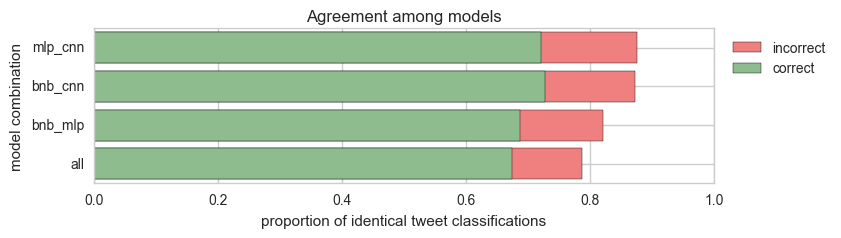

In [227]:
from collections import OrderedDict

agreement = OrderedDict()
agreement['all'] = sum((y_test_mlp == y_test_cnn) & (y_test_bnb == y_test_cnn))
agreement['bnb_mlp'] = sum(y_test_bnb == y_test_mlp)
agreement['bnb_cnn'] = sum(y_test_bnb == y_test_cnn)
agreement['mlp_cnn'] = sum(y_test_mlp == y_test_cnn)

agreement_correct = OrderedDict()
agreement_correct['all'] = sum((y_test_mlp == y_test_cnn) & (y_test_bnb == y_test_cnn) \
                               & (y_test_bnb == y_test))
agreement_correct['bnb_mlp'] = sum((y_test_bnb == y_test_mlp) & (y_test_bnb == y_test))
agreement_correct['bnb_cnn'] = sum((y_test_bnb == y_test_cnn) & (y_test_cnn == y_test))
agreement_correct['mlp_cnn'] = sum((y_test_mlp == y_test_cnn) & (y_test_mlp == y_test)) 

n_tweets = len(y_test)

print('MODELS', 'AGREEMENT', 'AGREEMENT_CORRECT', sep = '\t\t')
for key, value in agreement.items():
    agreement[key] = value / n_tweets
    agreement_correct[key] = agreement_correct[key] / n_tweets
    print(key, agreement[key], agreement_correct[key], sep = '\t\t')

fig, ax = plt.subplots(figsize = (8,2))
ax.barh(list(range(len(agreement))), agreement.values(), align = 'center', color = 'lightcoral', label = 'incorrect')
ax.barh(list(range(len(agreement_correct))), agreement_correct.values(), align = 'center', color = 'darkseagreen',
        label = 'correct')
ax.legend(bbox_to_anchor = [1.2,1])
__ = ax.set(yticks = list(range(len(agreement))), yticklabels = agreement.keys(), title = 'Agreement among models',
           xlabel = 'proportion of identical tweet classifications', ylabel = 'model combination', xlim = (0, 1))

That BNB and MLP have the least amount of agreement can be attributed to the fact that BNB had the best recall for hate speech tweets while MLP had the worst. That MLP could not classify a single instance of hate speech also explains why MLP and CNN do not agree more, as one might expect.

# Multi-class F1
The multi-class F1-scores tell a similar story to that of the confusion matrices for each model: BNB has the most success in identifying hate speech while MLP fails to detect any (in fact, MLP has the weakest F1-scores across all categories). Even though the CNN's accuracy and F1-scores for non-offensive and offensive speech are higher than that for BNB, its struggles with identifying hate speech results in a slightly lower overall F1-score than that of BNB.

,non-offensive,offensive,hate speech
Bernoulli Naive Bayes,0.904103,0.696094,0.436222
Multilayer Perceptron,0.904477,0.721354,0.000000
Convolutional Neural Network,0.927954,0.734854,0.344671


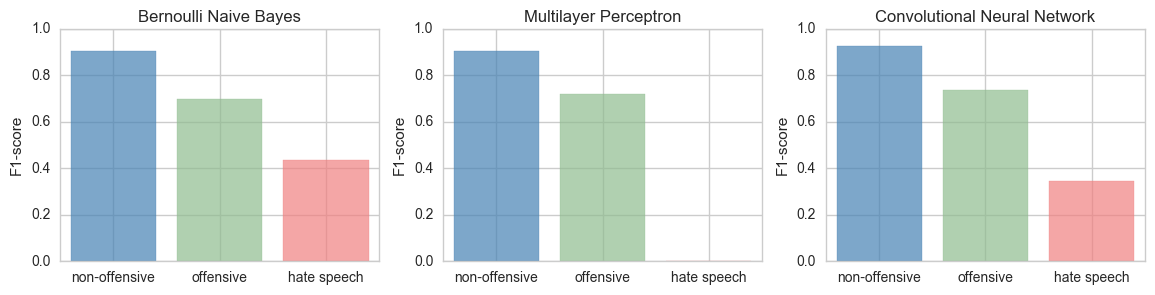

In [240]:
f1_bnb = f1_score(y_test_bnb, y_test, average = None)
f1_mlp = f1_score(y_test_mlp, y_test, average = None)
f1_cnn = f1_score(y_test_cnn, y_test, average = None)

f1_list = [f1_bnb, f1_mlp, f1_cnn]
xticklabels = ['non-offensive','offensive','hate speech']

fig, axes = plt.subplots(1, 3, figsize = (14, 3))
for ax, f1, title in zip(axes, f1_list, models):
    rects = ax.bar([0,1,2], f1, align = 'center', alpha = 0.7)
    ax.set(title = title, ylabel = 'F1-score', xticks = [0,1,2],
           xticklabels = xticklabels, ylim = (0,1))
    rects[0].set_color('steelblue')
    rects[1].set_color('darkseagreen')
    rects[2].set_color('lightcoral')
    
pd.DataFrame(f1_list, index = models, columns = xticklabels)

However, when the distinction between offensive language and hate speech is removed and the two categories are combined, the CNN outperforms BNB in both accuracy and F1-score. We will see later why the distinction is nebulous enough to justify discounting it

,accuracy,f1_score
model,,
Bernoulli Naive Bayes,0.895823,0.885977
Multilayer Perceptron,0.898370,0.891429
Convolutional Neural Network,0.923586,0.918655


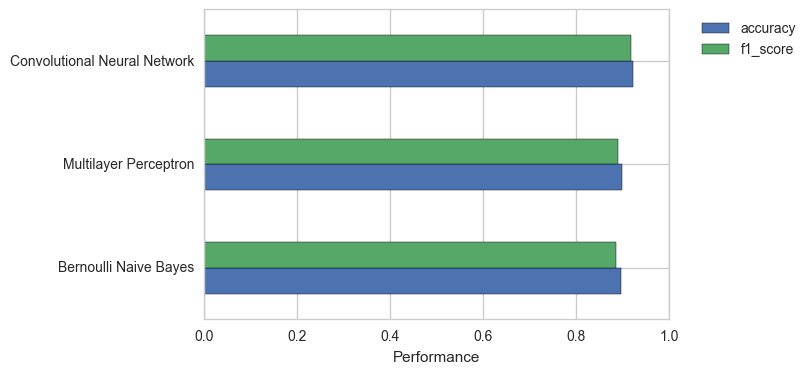

In [241]:
y_test_binary = y_test > 0
y_test_bnb_binary = y_test_bnb > 0
y_test_mlp_binary = y_test_mlp > 0
y_test_cnn_binary = y_test_cnn > 0

f1_binary_bnb = f1_score(y_test_bnb_binary, y_test_binary, average = 'binary')
f1_binary_mlp = f1_score(y_test_mlp_binary, y_test_binary, average = 'binary')
f1_binary_cnn = f1_score(y_test_cnn_binary, y_test_binary, average = 'binary')

accuracy_binary_bnb = accuracy_score(y_test_bnb_binary, y_test_binary)
accuracy_binary_mlp = accuracy_score(y_test_mlp_binary, y_test_binary)
accuracy_binary_cnn = accuracy_score(y_test_cnn_binary, y_test_binary)

f1_binary_list = [f1_binary_bnb, f1_binary_mlp, f1_binary_cnn]
accuracy_binary_list = [accuracy_binary_bnb, accuracy_binary_mlp, accuracy_binary_cnn]
    
df_plot = pd.DataFrame(dict(model = models, f1_score = f1_binary_list, accuracy = accuracy_binary_list))
ax = df_plot.plot(kind = 'barh')
__ = ax.set(yticklabels = models, xlabel = 'Performance')
ax.legend(bbox_to_anchor = (1.3,1))

df_plot.set_index('model')

# Model and panel confidence
Prior to making a prediction in multi-class classification, a model first generates a set of probabilities that a given tweet belongs in each class. The class with the highest probability is the one the tweet is classified as, and that probability can also be thought of as the model's confidence in its prediction.

Because all three models have the highest and lowest F1-scores for non-offensive and hate speech, respectively, we expect the models to also classify non-offensive speech with the greatest confidence and hate speech with the least confidence, and this is indeed the case. However, comparing the confidence for the same classification across different models is a less fruitful exercise. While MLP has the lowest F1-score for non-offensive speech, it classifies tweets as non-offensive with the highest confidence of the three models. Similarly, BNB's confidence in its classifications of offensive speech is higher than that of CNN's despite having a lower F1-score for that class.

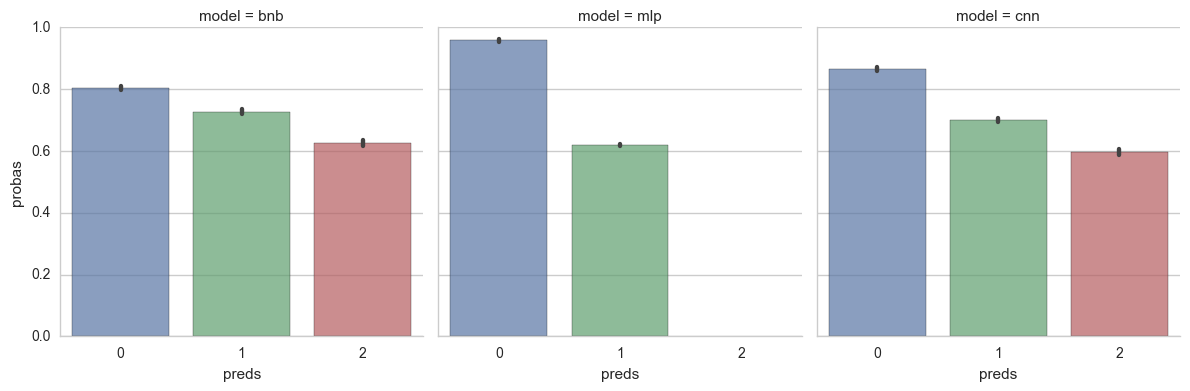

In [242]:
preds = np.concatenate([y_test_bnb, y_test_mlp, y_test_cnn])
probas = np.concatenate([max_proba_bnb, max_proba_mlp, max_proba_cnn])
model = ['bnb'] * n_tweets + ['mlp'] * n_tweets + ['cnn'] * n_tweets

data = dict(preds=preds, probas=probas, model=model)
df_preds = pd.DataFrame(data, index = list(y_test.index) * 3)

sns.factorplot(data = df_preds, x = 'preds', col = 'model', y= 'probas', kind = 'bar', alpha = 0.7)

If for all the models, the more offensive the class a tweet is assigned to, the less confident the model is in that classification, is the same true when people are classifying the tweets?

For this dataset of tweets, each tweet's offensiveness was judged by a voting panel of at least three people. The extent to which the judges agree on the classification is recorded for each tweet as an attribute called "confidence," which we refer to as "panel confidence" to distinguish it from "model confidence." How exactly the panel confidence is calculated is not documented, but the distribution suggests that panel confidence might correlate closely with the proportion of judges whose votes agree with the final classification.

It turns out that, like the models, the judging panels are also less confident when classifying a tweet into a more offensive category, with panel confidence dropping from 0.94 for non-offensive speech to 0.74 to hate speech. This adds more credence to the idea that the struggle to distinguish offensive speech from hate speech is not limited to models; humans have trouble deciding as well. 

mean panel confidence, non-offensive: 0.9403321179783616
mean panel confidence, offensive: 0.8138421149849959
mean panel confidence, hate speech: 0.7435890936254996


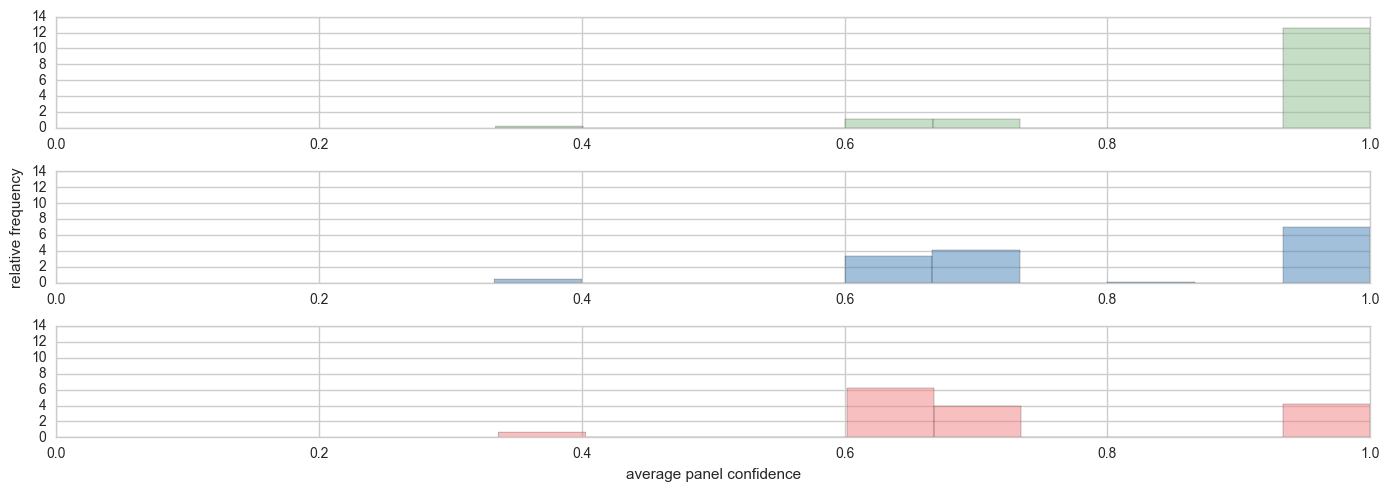

In [245]:
nonoffensive_conf = df_clean[y == 0].confidence
offensive_conf = df_clean[y==1].confidence
hate_conf = df_clean[y==2].confidence

fig, axes = plt.subplots(3, 1, figsize = (14, 5))

nonoffensive_conf.hist(normed = True, bins = 10, ax = axes[0], alpha = 0.5, color = 'darkseagreen')
offensive_conf.hist(normed = True, bins = 10, ax = axes[1], alpha = 0.5, color = 'steelblue')
hate_conf.hist(normed = True, bins = 10, ax = axes[2], alpha = 0.5, color = 'lightcoral')
axes[1].set(ylabel = 'relative frequency')
axes[2].set(xlabel = 'average panel confidence')
for ax in axes:
    ax.set(xlim = (0,1), ylim = (0,14))
plt.tight_layout()
print('mean panel confidence, non-offensive:', nonoffensive_conf.mean())
print('mean panel confidence, offensive:', offensive_conf.mean())
print('mean panel confidence, hate speech:', hate_conf.mean())

In [246]:
all_correct = (y_test_mlp == y_test_cnn) & (y_test_bnb == y_test_cnn) & (y_test_bnb == y_test)
all_incorrect = (y_test_mlp == y_test_cnn) & (y_test_bnb == y_test_cnn) & (y_test_bnb != y_test)
some_correct = all_correct != all_incorrect

It stands to reason that those tweets that were misclassified by all three models might also be ones that the panel struggled with, and the data below bears this out; the average panel confidence of tweets misclassified by all models is 0.713, much lower compared to that of tweets correctly classified by all models (0.923).

mean panel confidence, all correct: 0.9212236961451253
mean panel confidence, some correct: 0.8913983176965394
mean panel confidence, all incorrect: 0.7140546067415718


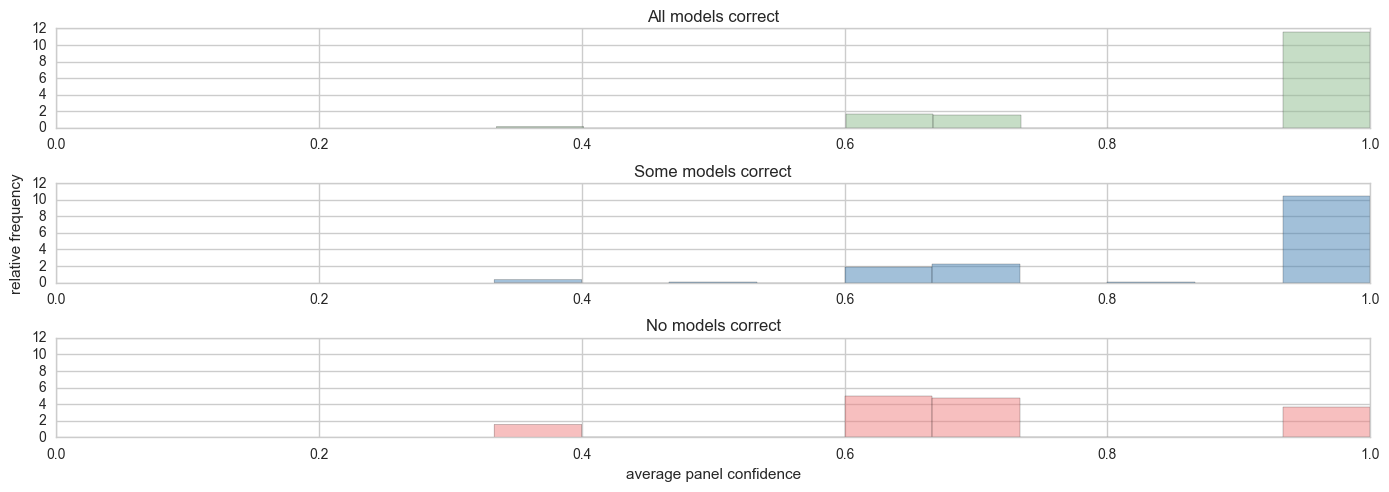

In [250]:
df_clean_test = df_clean.reindex(y_test.index)
fig, axes = plt.subplots(3, 1, figsize = (14, 5))

all_correct_conf = df_clean_test[all_correct]['confidence']
some_correct_conf = df_clean_test[some_correct]['confidence']
all_incorrect_conf = df_clean_test[all_incorrect]['confidence']

all_correct_conf.hist(normed = True, bins = 10, ax = axes[0], alpha = 0.5, color = 'darkseagreen')
some_correct_conf.hist(normed = True, bins = 10, ax = axes[1], alpha = 0.5, color = 'steelblue')
all_incorrect_conf.hist(normed = True, bins = 10, ax = axes[2], alpha = 0.5, color = 'lightcoral')
axes[0].set(title = 'All models correct')
axes[1].set(ylabel = 'relative frequency', title = 'Some models correct')
axes[2].set(xlabel = 'average panel confidence', title = 'No models correct')
for ax in axes:
    ax.set(xlim = (0,1), ylim = (0,12))
plt.tight_layout()
print('mean panel confidence, all correct:', all_correct_conf.mean())
print('mean panel confidence, some correct:', some_correct_conf.mean())
print('mean panel confidence, all incorrect:', all_incorrect_conf.mean())

Given that panel confidence is lowest for those tweets judged to contain hate speech as well as those tweets misclassified by all models, it makes sense that those tweets misclassified by all models would have a much higher proportion of hate speech. Broadly speaking, the trend is clear: tweets whose offensiveness is ambiguous enough for judges to disagree on their classification are also tweets that models will likely misclassify.

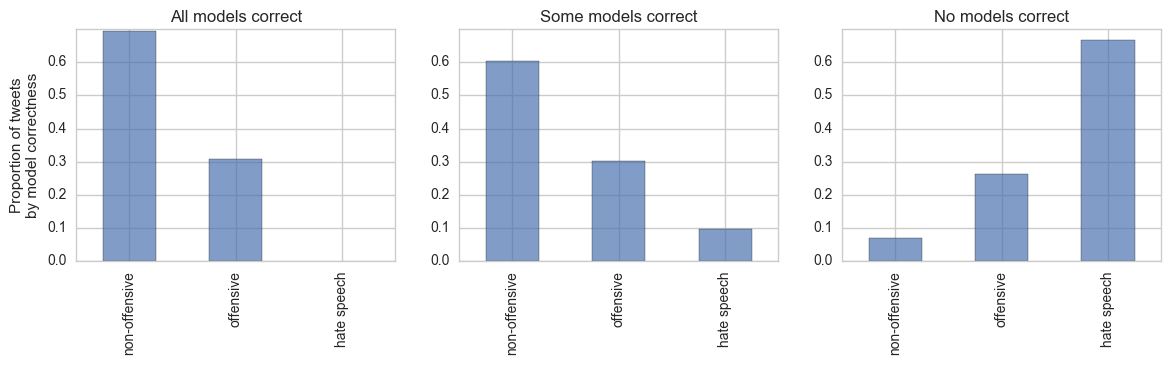

In [251]:
fig, axes = plt.subplots(1, 3, figsize = (14, 3))

dist_all_correct = y_test[all_correct].value_counts().sort_index() / len(y_test[all_correct])
dist_some_correct = y_test[some_correct].value_counts().sort_index() / len(y_test[some_correct])
dist_all_incorrect = y_test[all_incorrect].value_counts().sort_index() / len(y_test[all_incorrect])

dist_all_correct.plot(kind = 'bar', ax = axes[0], title = 'All models correct', alpha = 0.7)
dist_some_correct.plot(kind = 'bar', ax = axes[1], title = 'Some models correct', alpha = 0.7)
dist_all_incorrect.plot(kind = 'bar', ax = axes[2], title = 'No models correct', alpha = 0.7)

axes[0].set(ylabel = 'Proportion of tweets\nby model correctness')

for ax in axes:
    ax.set(xticks = [0,1,2], xticklabels = ['non-offensive', 'offensive', 'hate speech'], xlim = (-0.5,2.5),
           ylim = (0, 0.7))

It should be noted, however, that while there is some general correlation between panel confidence and the ability of the models to correctly classify a tweet, panel confidence does not correlate very well with average model confidence.

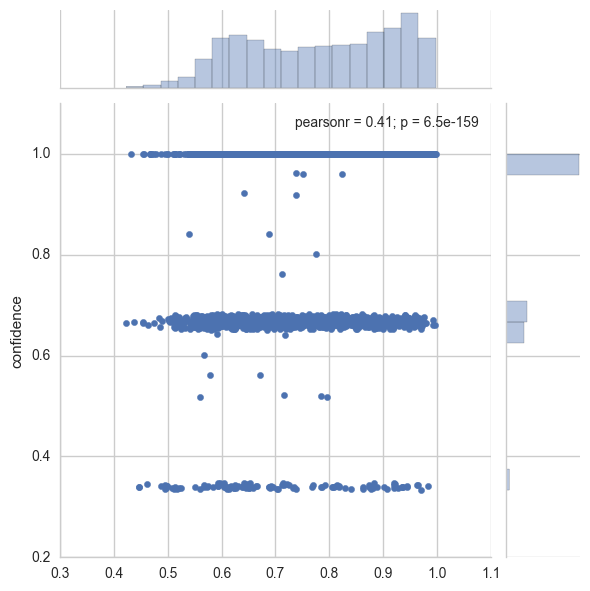

In [262]:
max_probas = np.column_stack([max_proba_bnb, max_proba_mlp, max_proba_cnn])
model_conf = max_probas.mean(axis = 1)
panel_conf = df_clean.reindex(y_test.index).confidence

sns.jointplot(model_conf, panel_conf, kind = 'scatter')

# Actual tweets
Below we display random samples of tweets, both unanimously correctly classified and unanimously misclassified.

### Unanimously correctly classified non-offensive tweets, highest avg model confidence
To understand which non-offensive tweets all three models are most comfortable classifying, we rank the tweets by their average model confidence and print the top results. Despite the political bent of a few tweets, these tweets are indeed pretty innocuous. Some recurring non-stop words are: Christmas, right (both in terms of rights and political leaning), and follow/follower. 

In [438]:
max_probas = np.column_stack([max_proba_bnb, max_proba_mlp, max_proba_cnn])
avg_probas = max_probas.mean(axis = 1)
df_orig = data_all['df_orig']
df_orig = df_orig.reindex(y_test.index)
df_orig['model_confidence'] = avg_probas

unanimous = (y_test_mlp == y_test_cnn) & (y_test_bnb == y_test_cnn)
y_test_all = y_test_cnn.copy()
y_test_all[~unanimous] = -1

bnb_cnn = y_test_bnb == y_test_cnn
y_test_bnb_cnn = y_test_cnn.copy()
y_test_bnb_cnn[~bnb_cnn] = -1

conf11 = df_orig[(y_test_all == 0) & (y_test == 0)].sort_values(by = 'model_confidence', ascending = False)
conf11_mean = conf11.confidence.mean()
conf11.head(10)

,text,rating,confidence,model_confidence
id,,,,
853722403,@Harry_Styles Hello H����\nChristmas is in a few days and your follow would be the best gift always.\nKindly follow me?\nAll the love. xx\n-60.956,0,1.0000,0.997362
853727166,You have the right to celebrate Christmas any way you please or not at all &amp; the Religious Right can't stand that. https://t.co/5Odq5y6N38,0,1.0000,0.996442
853733025,Is your religion more important than humanity. ?? More important than life itself ??. Then you have no right to live on this planet,0,0.6605,0.996140
853719823,Start the new year off creatively - book in for Ingrid Morley's 3 Day Summer Workshop: 'Fired! Ceramic Figure in... https://t.co/2MhPN6ecZH,0,1.0000,0.995350
853722435,"The #SecretService requires a fresh start devoid of any non-critically thinking idiots...and for good measure, any right-wing-nut-jobs.",0,1.0000,0.994840
853729859,"6 new followers in the last week and it is more than just stats, I use it for growing my account! Try it https://t.co/gIXrTBbkaP",0,1.0000,0.993369
853722908,"So Malcolm X, and Black Panther movement had no merit? It might not be right but how can you blame the victims? https://t.co/cM9sY7t8Nm",0,1.0000,0.993132
853723509,Not that I need or want full frontal nudity but I for sure there should be equal opportunity. #showyourbacon https://t.co/csquiI2E4W,0,1.0000,0.993065
853720000,"@Chinks_kj @RJSudeshBhat I am literally in tears, Want more people to work this way for a better place to live. Great work and good luck!!",0,1.0000,0.992713


### Unanimously correctly classified non-offensive tweets, lowest avg model confidence
In contrast to the tweets above with the highest average model confidence, unanimously correctly classified non-offensive tweets with the lowest average model confidence are more casual, incorporating much more slang and text-speak: lmao, tbh, rn, coz, ... Interestingly, even though capitalization is ignored during classification because all tokens are converted to lowercase during preprocessing, there still exists a noticeable difference in the attention paid to capitalization between the non-offensive tweets most confidently and least confidently classified.

The recurring stop words here are decidedly less positive or neutral: hate, white, and chink. While the tweets in which these words appear are indeed harmless, these terms are so frequently present in more offensive tweets that the models cannot be more certain that these tweets are non-offensive.

In [416]:
conf11.tail(10).sort_values(by = 'model_confidence', ascending = False).tail(10)

,text,rating,confidence,model_confidence
id,,,,
853724832,@Almightyvonzus lmaoooo the hate you're getting_�㢉�_�__�㢉�_�_,0,1.0000,0.598471
853721206,Wow that sand is white https://t.co/Ixv5vjxsLv,0,1.0000,0.598212
853731908,I knew it wasn't gonna be nice today like they said it was _̫_̨,0,1.0000,0.590595
853723136,"BJP won't show chinks in its armour &amp; backs Jaitley, for solidarlty &amp; to maintain Party morale. But this chink is big. @BillionIndian @dna",0,1.0000,0.589321
853732173,"@crybabycait they all look the same/do the same things, it's so boring tbh",0,1.0000,0.562433
853725290,@ArviIgnacio @maxespinatan siomai is white and wrinkly.. BEEF BALL IN GINGER SAUCE AND HOT SAUCE,0,1.0000,0.550102
853720510,"@BiancaRucker @gates_mcfadden ...listen, listen, listen....you're not listening to me! https://t.co/VoiNUROQcm",0,1.0000,0.547885
853724700,I hate all my teachers rn,0,0.6700,0.546955
853725291,i was so tempted to upload this pic to my @USCIS visa app coz technically the background is white s/o @unicef _������ https://t.co/65x0zaai9G,0,0.6701,0.546815


### Unanimously correctly classified offensive tweets, highest average model confidence
These tweets are substantially more vulgar than the non-offensive tweets, with "fuck", "nigga", "lame", "bitch", "wit", "cuff", and "hoes" being the most common non-stop words. Curiously, despite the high frequency of "nigga" among these tweets, "nigger" is no where to be found because the latter is more often associated with hate speech. 

In [437]:
conf22 = df_orig[(y_test_all == 1) & (y_test == 1)].sort_values(by = 'model_confidence', ascending = False)
conf22_mean = conf22.confidence.mean()
conf22.head(10)

,text,rating,confidence,model_confidence
id,,,,
853732446,I always wonder what my future wife is doing right now. She prolly fucking wit a lame nigga who still doin lil boy shit. Be patient bae,1,1.0000,0.869361
853732405,She was not fuckin around wit a lame das why I treat all dese bitches da same,1,1.0000,0.864319
853730176,"I don't be cuffin these hoes, I just be fuckin these hoes.",1,1.0000,0.863221
853723379,I ain't be cuffin these hoes I just be fuckin these hoes,1,1.0000,0.861556
853731178,I always run into these amazing ass girls when they're cuffed up like where you was at prior to this lame nigga you obsessed wit? Lmao,1,1.0000,0.857448
853732438,Wen u introduce a nigga to real he shud Neva fuck wit a lame,1,1.0000,0.855466
853732421,Just know u ain't fuckin wit a lame baby _̫���_̫����,1,0.6725,0.852858
853730193,_̫�Љۡ_̫�Љۡ_̫�Љۡ why y'all cuffin these hoes man,1,1.0000,0.852404
853732407,She fucking wit a lame!!!_̫��_�_����,1,0.6774,0.852373


### Unanimously correctly classified offensive tweets, lowest average model confidence
The offensive tweets classified with the lowest average model confidence contain none of the recurring non-stop words from above, and with the exception of "fag" do not appear to display other notable word frequency properties. We can glimpse from these tweets however that the judges and models do not necessarily label tweets by the offensiveness of the idea motivating them, but rather just the presence of certain types of language. Take for example:
> 9.50 for a packet of fags.. Robbery pure robbery

Almost certainly, this tweet was flagged as offensive by a majority of judges for containing the word "fag" even though in the context of this sentence, the term refers to cigarettes. This ambiguity is reflected in the tweets' relatively low panel confidence. Similarly, the very short tweet:
> butt ugly

is so short its devoid of meaning entirely, so it is judged solely on the language employed. Finally, the labeling of:
> she bashes queers and apoligizes for sexual harassment and rape as an #fitzgibbonmedia trainee

is perhaps the most questionable with its extremely low panel confidence of 0.34. While idea motivating the tweet may be mean-spirited, it is not offensive, so it was likely labeled as such only because the tweet discusses "queers", "sexual harrassment", and "rape."

In [419]:
conf22.tail(10)

,text,rating,confidence,model_confidence
id,,,,
853725041,@jsgil_ we got a problem here faggot??,1,1.0000,0.538584
853733803,@Declassae you left me fag,1,1.0000,0.532959
853721007,she bashes queers and apoligizes for sexual harassment and rape as an #fitzgibbonmedia trainee @DrewMinerTX @scootey @KailiJoy,1,0.3367,0.525394
853726499,���9.50 for a packet of fags.. Robbery pure robbery,1,0.6528,0.524537
853722989,Damn! That @flotus is a butt ugly skank! https://t.co/mzx5HqNSrD,1,1.0000,0.511693
853729344,@PoliticsKibow Larry O'Donnel is a Fag and any Obama supporter is an enemy.,1,0.6667,0.508976
853722028,@benshapiro if you don't want to be called a teabagger...... https://t.co/ChZRCOEQCJ,1,0.6718,0.500162
853731694,"@RebootingDavid They're high schoolers. They're quite aware of white trash hate. This is their world, too. No one expects you to understand.",1,1.0000,0.469092
853727137,@LordWaynie LMFAO whenever I hear tht movie name I think of Eric bullying Josh in highschool calling him a fkn spear chucker,1,1.0000,0.467797


### Correctly classified hate speech tweets (BNB and CNN), highest avg model confidence
Because MLP did not classify a single tweet as hate speech, we only consider hate speech tweets correctly classified by BNB and CNN. We easily see that these tweets revolve around two main terms: "faggot" and "nigger". Here again we see that hate speech is not distinguished from offensive speech by the idea driving the statement but rather just the words present. For many of these tweets, simply replacing "nigger" or "faggot" with a less offensive term would likely result in a different decision by the judges.

In [436]:
conf33 = df_orig[(y_test_bnb_cnn == 2) & (y_test == 2)].sort_values(by = 'model_confidence', ascending = False)
conf33_mean = conf33.confidence.mean()
conf33.head(10)

,text,rating,confidence,model_confidence
id,,,,
853732043,"""you fucking faggot! you're the biggest faggot that ever faggoted!""",2,1.0000,0.761147
853732053,"Find ""literally"" the biggest faggot https://t.co/46UsLSvmf8",2,1.0000,0.742131
853727243,@DareToPepe @schoolshooterye @KEEMSTARx shut the fuck stupid nigger faggot,2,0.6667,0.739926
853724375,@moonlightmid @MilqShakes THIS LESBIAN DUMB FUCKING NIGGER BITCH https://t.co/Dn8MXSXtzm,2,1.0000,0.735489
853720910,"@MrVasNormandy I hate niggers I hate traitors I hate traitor niggers in space\n\n-Tonfa Moonman Trooper, 2015",2,0.6701,0.733918
853724255,Ur?\nWhat ur?\nUr nice?\nUr handsome?\nUr a great big fucking faggot? https://t.co/B0416P6zXT,2,0.6684,0.726697
853726332,@anaImiIk @OBSIDIANx nigger music is ghetto nigger music is trash,2,1.0000,0.713020
853723459,youre a dumb nigger https://t.co/IZb5BSNFeq,2,0.6633,0.710018
853723420,@KSIOlajidebt dumb nigger,2,1.0000,0.705862


### Correctly classified hate speech tweets (BNB and CNN), lowest avg model confidence
Correctly classified hate speech tweets with the lowest model confidence still revolve around "faggot" and "nigger".

In [421]:
conf33.tail(10)

,text,rating,confidence,model_confidence
id,,,,
853723681,.@rkelly you're a faggot ass rapist motherfucker and i'll literally end you,2,1.0000,0.574001
853720291,@iIlshowyou fuck yiu faggot theyre ouctures she fooled us all,2,0.6649,0.571931
853727760,Link up then faggot https://t.co/ZXNgtuclf8,2,0.6618,0.569961
853725007,"@MacMiller thank you, don't come here faggot.",2,0.6718,0.565066
853724395,my dog needs to sleep still fucking nigger,2,0.6650,0.563335
853721014,@slxyun @faiIxre Yeah lol anime is for queers.. Heh heh amirite?,2,0.6582,0.561124
853720366,@Only1Darty @exiLe_MonsteH u guys are still being faggots huh,2,0.6528,0.555715
853729490,@TroyMassa @SethNorton12 Troy is a faggot for real tho,2,1.0000,0.554660
853726389,@InternationalO not all blacks participated in the bus boycotts. Not all protested and marched. Some said those niggers are crazy.,2,0.6582,0.545787


### Hate speech tweets unanimously misclassified as non-offensive
Below is a random sample of 10 hate speech tweets that were unanimously classified as non-offensive. We can easily notice that almost of all of these tweets were originally labelled with some disagreement. It's hard to see how
> "Hercules is white male privilege"

and

> I wish that you were alive so I could tell you to kill yourself.

constitutes hate speech. Even the tweet labeled with a confidence of 1.0:
> go kill yourself!

is highly questionable as hate speech since there is no indication of prejudice to a particular group. This suggests that at least some of the models' misclassifications of hate speech are due to the arbitrary and ambiguous nature of labeling tweets as such in the first place.

Below is an example of a tweet classified as hate speech based on its ideas rather than language. 
> I think Israel meaning all of us, are sick to put up with any of them. They should be forced into exile. Or killed

However, we've seen previously many more cases where tweets were classified by language rather than idea, so the models learned to do the same, resulting in misclassifications like the one above.

In [435]:
conf31 = df_orig[(y_test_all == 0) & (y_test == 2)]
conf31_mean = conf31.confidence.mean()
conf31.sample(10)

,text,rating,confidence,model_confidence
id,,,,
853725292,"""Hercules is white male privilege""",2,0.3403,0.873456
853733647,@DonkeyShowPart2 a GERMAN kike!,2,0.3386,0.786372
853725614,@BBhuttoZardari go kill yourself!,2,1.0000,0.768633
853726160,Picking up Zoe's boyfriend from practice yet didn't take off my coon slippers,2,0.6684,0.754825
853720485,"@AviMayer @asyoureadthis I think Israel meaning all of us, are sick to put up with any of them. They should be forced into exile. Or killed",2,0.6684,0.956377
853721894,@POTUS We can be called Wetbacks and Evert name in the book without any repercussions. It doesn't matter if Donto James told people he owned,2,0.6528,0.918909
853725622,@IHE_OFFICIAL I wish that you were alive so I could tell you to kill yourself.,2,0.3385,0.935764
853724537,"@SexiestPatriot Which Swedish women are of rapable age? 2 years old to 92 years old? Some will get raped twice a week. Others, who knows?",2,0.6582,0.781005
853733665,Ko me kike soe I go buy,2,0.6667,0.864244


### Non-offensive tweets misclassified as hate speech by BNB and CNN
There is only one case of a non-offensive tweet misclassified as hate speech, but it further illustrates the arbitrariness introduced by having small panels label the tweets initially.

Below is an example of a tweet labeled initially as hate speech, ostensibly because it contains the word "coon," which if removed from the tweet, would have likely removed the entirety of the tweets' offensiveness.
> Picking up Zoe's boyfriend from practice yet didn't take off my coon slippers

It's curious then that
> Biggest coon ever

would be labelled as non-offensive, an inconsistent judgement that the models naturally would not be able to reconcile.



In [434]:
conf13 = df_orig[(y_test_bnb_cnn == 2) & (y_test == 0)]
conf13_mean = conf13.confidence.mean()
conf13

,text,rating,confidence,model_confidence
id,,,,
853733869,Biggest coon ever https://t.co/kGeoDpY8rP,0,0.6684,0.502595


### Hate speech tweets unanimously misclassified as offensive

In [451]:
conf32 = df_orig[(y_test_all == 1) & (y_test == 2)]
conf32_mean = conf32.confidence.mean()
conf32.sample(10)

,text,rating,confidence,model_confidence
id,,,,
853724463,@JaAllsopp @maynardcontract @Marco_P_Shite @Floatdownhere Stroll up The Orme . . . Fucking queer bastard,2,0.6633,0.680750
853732529,If you a fag and u dress like girl please be a neat one cause these people I be seeing look a HOT ASS MESS_̫��__̫��__̫��__̫��_,2,1.0000,0.808733
853727351,@GennadyAli that faggot waits for me to post more pics of me so he can use them for pleasure,2,1.0000,0.584017
853723837,Cant believe that nigga steven fernandez or Switch God Faggot smh these niggas deserve to get their assholes pushed in _�㢉�_�۝,2,1.0000,0.783000
853723214,wonder what type of off the wall coon shit Steve Harvey was saying tonight,2,0.6768,0.630560
853726358,Every time I'm on my Xbox some white boy always tell me to off my nigger music off _̫�Љۡ_̫�Љۡ,2,0.6615,0.645207
853727265,@Jdm_giovanni Lmaooo in February watch that fag gonna get his,2,1.0000,0.678146
853718220,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkillah Is a fag"" jackie jealous"" Neeeee",2,0.5184,0.559182
853733828,@stylesftoml I KNOW FAG IM CRUIFNF,2,1.0000,0.624197


Based on the examples of hate speech that were correctly classified with high confidence, we expect a number of the tweets below to have been correctly classified as well, most notably the ones containing "nigger" and "faggot." However, the fact that these tweet containing those words are misclassified suggests there exists a large number of offensive tweets containing the same terms. A random sample of those tweets are displayed below, and perplexingly, they seem no different from the ones classified as hate speech.

In [456]:
df_orig[(y_test == 1) & (df_orig.text.str.contains('nigger') | df_orig.text.str.contains('faggot'))].sample(10)

,text,rating,confidence,model_confidence
id,,,,
853720894,All niggers beware https://t.co/qZ4BNsMId9,1,0.6736,0.627872
853720843,"my grandma- ""whew! I'm sweating like a nigger on Election Day"" _�㢉�_��",1,0.6616,0.606149
853725004,@Jessewelle @Banks @mariocreates come here faggot,1,0.6599,0.608033
853724165,Dude...He could care less you dumb fuckin faggot! LOL https://t.co/XCHGYbP9VV,1,0.6702,0.613158
853732016,"@James_R_Dowdle nothing, ur still a faggot",1,0.6678,0.613757
853729435,I think I'm just gonna be a faggot and eat mall food idc that shit was fuego,1,0.6673,0.653049
853732004,AIDS still a faggot disease.,1,0.6598,0.574780
853726283,"Calling me a nigger is insignificant, when society is structured to treat me like one._̫���",1,0.6717,0.636244
853722879,"@Gerikoteci @jmbball25 Geri, you're the biggest faggot ik.",1,1.0000,0.650703


From the initial sample of misclassified hate speech, there were also a number of tweets containing "fag" that were originally labelled as hate speech. Recall that "fag" appeared frequently as a word in tweets correctly classified as offensive but with low model confidence. This begs the question, when is using "fag" considered offensive and when is it considered hate speech? Here as well, the answer is not clear.

In [460]:
df_orig[(y_test == 2) & (df_orig.text.str.contains('fag') & ~df_orig.text.str.contains('faggot'))].sample(10)

,text,rating,confidence,model_confidence
id,,,,
853728846,@jotkaur_ you just tweeted yourself you fag,2,0.6616,0.558528
853723534,@endthisin2016 im a fag and i think this tweet is fucking gay and stupid ill say whatever tf i want,2,0.6587,0.763936
853727265,@Jdm_giovanni Lmaooo in February watch that fag gonna get his,2,1.0000,0.678146
853720381,@janoangels &amp; I don't like fags or weed so://,2,0.6650,0.575315
853730760,Any nigga gossip about another nigga is a fag,2,1.0000,0.612222
853726502,I smell of fags ew,2,1.0000,0.567651
853730734,@yungpIus karenh is my girlfriend and bury is a fag,2,1.0000,0.592098
853727300,@BAMAPERRY This was cool until I saw that fag Grahmnesty,2,1.0000,0.559233
853732520,@BOOFBOIICY @Uptown_Jordan Jordan I'm convinced you a fag,2,0.6754,0.653733


In [465]:
df_orig[(y_test == 1) & (df_orig.text.str.contains('fag') & ~df_orig.text.str.contains('faggot'))].sample(10)

,text,rating,confidence,model_confidence
id,,,,
853729398,Don't wanna have a fag but my shisha pen ent working,1,1.0000,0.642011
853728818,Wtf is my timeline. Stop rting shit you fag,1,0.6734,0.637376
853720372,"No goofies , no fashion fags https://t.co/faeiUynDFK",1,0.6751,0.620172
853733795,need tea and a fag... with food and then all thats missing would be bae...,1,1.0000,0.584940
853724092,The 'lipstick young' (fags) are even a problem for ISIS' recruiting.\n\nhttps://t.co/qVL23o3PK9 https://t.co/lnnB1Zhyzp,1,0.6735,0.607757
853728839,@mitchdez_ Yayyyy. I'm gonna bully you fag _̫��� (bully as in stare at you and not say hi _̫�Љۡ_̫�Љۡ),1,0.6788,0.695058
853723600,"_��̻_- fag, but you chill and uh text me",1,1.0000,0.588301
853733821,@tygerr23 hahah no u stop being a fag :),1,0.6768,0.587203
853720371,"@RealPhantomRaid @Xbox @PlayStation yall cant even spell ""go"" and you expect us to believe you can do that ha fags",1,1.0000,0.718309


### Offensive tweets misclassified as hate speech by BNB and CNN
Again, based on the number of correctly classified hate speech containing "nigger" and "faggot", the models reasonably expect these tweets to have been "hate speech" rather than "offensive."

In [432]:
conf23 = df_orig[(y_test_bnb_cnn == 2) & (y_test == 1)]
conf23_mean = conf23.confidence.mean()
conf23.sample(10)

,text,rating,confidence,model_confidence
id,,,,
853725119,@BigDaddyJohan is a ride or die &amp; I love his faggot ass ���_�̪�_��̻���_��̻��_��̻__��̻__��̻̣,1,1.0000,0.635488
853725870,@SupaBadMcLoving that little faggot lol,1,0.6717,0.698160
853725944,@WavyRez_ I see my nigga Rez with too many niggers _�㢉�_��� #Coolin,1,0.6612,0.587081
853723434,niqs is a dumb nigger,1,0.6650,0.697481
853725928,@CheekyRealize too many niggers selling illegal accessories tbh,1,0.6650,0.644801
853723740,you're such a faggot bitch,1,1.0000,0.626650
853720368,Most of you are circle jerking faggots tbh.,1,1.0000,0.606239
853725852,Hello little faggot _�㢉�_��__�㢉�_��__�㢉�_�__�㢉�_�_ https://t.co/wRIGFKcRyb,1,0.6580,0.693158
853732681,@jamesangus82 fuck off you fucking faggot,1,0.6510,0.580217


### Offensive tweets unanimously misclassified as non-offensive
While the line between offensive and hate speech is decidedly unclear, based on all three models' high F1-scores in classifying non-offensive speech, the same cannot be said about the difference between non-offensive and offensive tweets.

In [431]:
conf21 = df_orig[(y_test_all == 0) & (y_test == 1)]
conf21_mean = conf21.confidence.mean()
conf21.sample(10)

,text,rating,confidence,model_confidence
id,,,,
853731437,@KurtSchlichter only relevant if @tedcruz was married to a convicted perjurer and rapist.,1,0.6735,0.746378
853720017,"@trulybrazen Excellent! As you may know, schmuck is an effective, nasty schlong, while putz is an ineffective one. https://t.co/jJ6CtRPfx4",1,0.6667,0.965775
853720020,"@maudegarrett I heard there's some awesome street art in Berlin, like Banksy's famous ""Flower Chucker"".",1,0.6598,0.903722
853733641,@trensabby must be making more little inbred muzzie asswipes like u trying on ur dad!\n@a_leesha1 @abdul91533147,1,0.6564,0.727850
853722708,"When your family is so beautiful, they have to wear bags over their head and sell combs",1,0.6528,0.970105
853729055,"Same crap happens at work, if u r even slightly pretty,not fat, you r an outcast by those feminazi's https://t.co/ZvjQzCimBv",1,0.3384,0.934129
853733635,YET ANOTHER POS MUZZIE HEADING RIGHT TO HELL FAST -- JUST NOT FAST ENOUGH BAN ISLAM https://t.co/buCHeUFrcl,1,0.3402,0.817589
853720747,Early night for me spoil me while I'm away also rt follow I need more ..slaves sissy losers chastity sluts #findom #Femdom #sph #paypigs,1,1.0000,0.909150
853722038,"@MaggieMKOC @SexiestPatriot If you support their racist, sexist, &amp; homophobic ideology, you're a teabagger. You ARE as ignorant as they are",1,0.6751,0.892929


Of the sampled tweets above, some are clearly misclassified, especially but not limited to those containing the word "muzzie" (a derogatory term for Muslisms). Of course, a number of non-offensive tweets containing "muzzie", displayed below, should have been originally labelled as offensive or hate speech.

In [471]:
df_orig[(y_test == 0) & (df_orig.text.str.contains('muzzie'))]

,text,rating,confidence,model_confidence
id,,,,
853733630,They're not saying it but this was definitely terrorism and probably muzzie. https://t.co/vamflFFQNJ,0,0.6713,0.668769
853733622,"@ArcticFox2016.... of course not, muzzie obumma protecting his buddies",0,1.0000,0.867135
853733611,@thebeatgoeson23 The muzzie wench that shot up California posed a threat and made postings prior to coming but she got a visa with no prob,0,0.6684,0.847816
853733598,@carming33 definitely for muzzie removal,0,0.6546,0.892685


Of the offensive tweets misclassified as non-offensive, some also could reasonably be re-labelled as non-offensive, for example:
> I heard there's some awesome street art in Berlin, like Banksy's famous "Flower Chucker"

which seems to contain no offensive content at all, and:

> only relevant if @tedcruz was married to a convicted perjurer and rapist

which seems to refute or at the very least qualify someone else's potentially offensive comment.

### Non-offensive tweets unanimously misclassified as offensive
Similarly, the vast majority of sampled tweets below could arguably be re-labelled as offensive given the examples of offensive tweets already seen.

In [430]:
conf12 = df_orig[(y_test_all == 1) & (y_test == 0)]
conf12_mean = conf12.model_confidence.mean()
conf12.sample(10)

,text,rating,confidence,model_confidence
id,,,,
853727285,That fag Joey Grashita and his bf look like literal twins wtf.,0,0.3363,0.495224
853727168,Omg I Can't Stand That Mf'er ! He Give Me All The Bullets To Shoot Shots At His Ass _̫�Љۡ_̫��__̫_�_̫�_,0,0.6598,0.761261
853723985,Niggas is faggots _�㢉�_� like really still playing In My Face,0,0.3395,0.605086
853733815,"Girl asked me and Evan for a fag in town, she looked about 9 #paulstreet",0,0.6667,0.639705
853723259,"""You can help with these dishes or I can cover your escape to the gym... Run. Literally.""\nGod bless Papa T, saving my ass since 1994",0,0.3402,0.688683
853722665,I love how thick lips is a dominant trait but I deadass got stuck with thin ass white people lips _��̻���_��̻���_��̻���,0,0.6564,0.789102
853719942,Lil short ass_�㢉�__,0,0.3420,0.639227
853723206,@tariqnasheed Thank u for giving us heads up about the racist #StarWars script. I won't be going to see coon shit. https://t.co/ECPeq9aUFK,0,0.3403,0.605553
853728038,These poor little boys throwing up blood. Ain't ever been to a real hood. (And no the trailer park doesn't count) _̫�Ё�_̫̍�_̫�̩,0,0.6726,0.551404


# Panel confidence matrix
Finally, we construct a panel confidence matrix - it is laid out similarly as a confusion matrix, but instead of each cell represeting counts or proportions, each cell now represents the average panel confidence of all tweets described by the cell.

We see that those non-offensive tweets that were mis-classified as offensive or hate speech have much lower panel confidence scores, meaning there were many non-offensive tweets where at least one judge in the panel believed the tweet should be classified as offensive or hate speech. This suggests that at least some non-offensive tweet misclassifications may have been due to human error or the arbitrary nature of judging ambiguous cases. Similarly, tweets containing offensive or hate speech that are misclassified as non-offensive typically have much lower panel confidence as well.

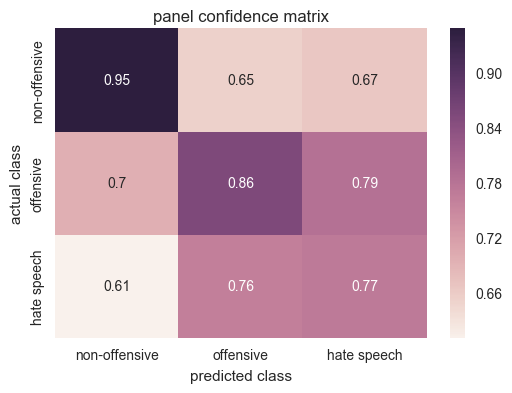

In [450]:
panel_conf = np.array([[conf11_mean, conf12_mean, conf13_mean],
                     [conf21_mean, conf22_mean, conf23_mean],
                     [conf31_mean, conf32_mean, conf33_mean]])

classes = ['non-offensive', 'offensive', 'hate speech']
ax = sns.heatmap(panel_conf, annot = True)
__ = ax.set(xlabel = 'predicted class', ylabel = 'actual class', xticklabels = classes,
            yticklabels = reversed(classes), title = 'panel confidence matrix')